In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


# === 1. Charger les fichiers CSV ===
attacking = pd.read_csv("../data/attacking.csv")
attempts = pd.read_csv("../data/attempts.csv")
defending = pd.read_csv("../data/defending.csv")
disciplinary = pd.read_csv("../data/disciplinary.csv")
distribution = pd.read_csv("../data/distributon.csv")
goalkeeping = pd.read_csv("../data/goalkeeping.csv")
goals = pd.read_csv("../data/goals.csv")
key_stats = pd.read_csv("../data/key_stats.csv")

# === 2. Nettoyage de base ===
attacking = attacking.fillna(0)
attempts = attempts.fillna(0)
defending = defending.fillna(0)
disciplinary = disciplinary.fillna(0)
distribution = distribution.fillna(0)
goalkeeping = goalkeeping.fillna(0)
goals = goals.fillna(0)
key_stats = key_stats.fillna(0)

# === 3. Minutes totales par équipe (base pour normalisation) ===
minutes_team = key_stats.groupby('club').agg({
    'minutes_played': 'sum'
}).reset_index().rename(columns={'minutes_played': 'total_minutes'})

# === 4. Agrégation par équipe des stats brutes ===
# Tirs et buts
attempts_team = attempts.groupby('club').agg({
    'total_attempts': 'sum',
    'on_target': 'sum'
}).reset_index()

goals_team = goals.groupby('club').agg({
    'goals': 'sum'
}).reset_index()

# Passes
distribution_team = distribution.groupby('club').agg({
    'pass_attempted': 'sum',
    'pass_accuracy': 'mean',
    'cross_attempted': 'sum'
}).reset_index()

# Défense
defending_team = defending.groupby('club').agg({
    'balls_recoverd': 'sum',
    'tackles': 'sum'
}).reset_index()

# Discipline
disciplinary_team = disciplinary.groupby('club').agg({
    'fouls_committed': 'sum',
    'fouls_suffered': 'sum'
}).reset_index()

# Gardien
goalkeeping_team = goalkeeping.groupby('club').agg({
    'saved': 'sum'
}).reset_index()

# Dribbles et centres
attacking_team = attacking.groupby('club').agg({
    'dribbles': 'sum',
    
}).reset_index()

# === 5. Fusionner toutes les stats ===
team_stats = attempts_team \
    .merge(goals_team, on='club', how='outer') \
    .merge(distribution_team, on='club', how='outer') \
    .merge(defending_team, on='club', how='outer') \
    .merge(disciplinary_team, on='club', how='outer') \
    .merge(goalkeeping_team, on='club', how='outer') \
    .merge(attacking_team, on='club', how='outer') \
    .merge(minutes_team, on='club', how='outer')

team_stats = team_stats.fillna(0)

# === 6. Normalisation par 90 minutes ===
cols_to_normalize = [
    'balls_recoverd',
    'tackles',
    'fouls_committed',
    'fouls_suffered',
    'saved',
    'dribbles',
    'cross_attempted'
]

for col in cols_to_normalize:
    team_stats[col + '_per90'] = team_stats.apply(
        lambda row: (row[col] / row['total_minutes']) * 90 if row['total_minutes'] > 0 else 0,
        axis=1
    )

# === 7. Résultat final ===
print(team_stats.head())

# (Optionnel) Sauvegarde dans un fichier CSV
team_stats.to_csv("team_stats_normalized.csv", index=False)


        club  total_attempts  on_target  goals  pass_attempted  pass_accuracy  \
0       Ajax             131         52     21            4488      85.456250   
1   Atalanta              81         30     12            2921      78.927778   
2   Atlético              96         27      9            3509      76.520000   
3  Barcelona              60         11      2            3498      86.825000   
4     Bayern             192         70     30            6147      87.531579   

   cross_attempted  balls_recoverd  tackles  fouls_committed  ...  saved  \
0              159             327      107              117  ...     15   
1              102             280       65               68  ...     21   
2              117             474      132              139  ...     26   
3              118             235       89               83  ...     16   
4              209             439       92              115  ...     18   

   dribbles  total_minutes  balls_recoverd_per90  tackle

In [3]:

# ===============================
# 📥 Charger le dataset par équipe
# ===============================
team_stats = pd.read_csv("team_stats_normalized.csv")

# ===============================
# 🧹 Sélection des colonnes numériques à clusteriser
# ===============================
# On exclut 'club' qui est une variable catégorielle
num_cols = [
    'total_attempts',
    'on_target',
    'goals',
    'pass_attempted',
    'pass_accuracy',
    'balls_recoverd_per90',
    'tackles_per90',
    'fouls_committed_per90',
    'fouls_suffered_per90',
    'saved_per90',
    'dribbles_per90',
    'cross_attempted_per90'
]

num_df = team_stats[num_cols]

# ===============================
# 📏 Standardisation des données
# ===============================
scaler = StandardScaler()
X = scaler.fit_transform(num_df)


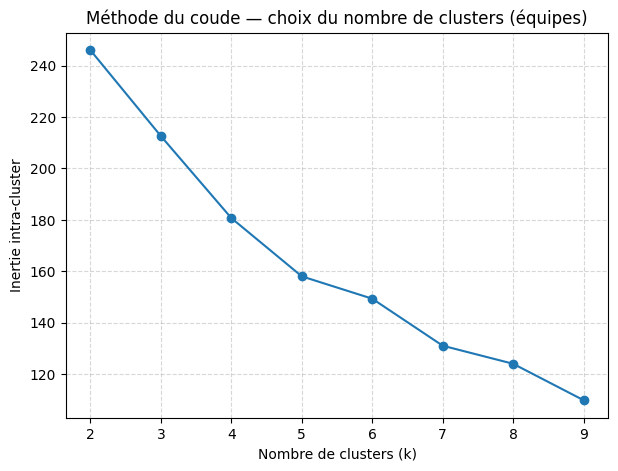

In [4]:
# ===============================
# 📊 Méthode du coude pour choisir k
# ===============================
inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(range(2, 10), inertias, marker='o')
plt.title("Méthode du coude — choix du nombre de clusters (équipes)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [5]:
# ===============================
# 🧠 KMeans avec le meilleur k
# ===============================
best_k = 4  # 👉 Ajuste ce nombre selon le coude obtenu
kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
team_stats["cluster"] = kmeans.fit_predict(X)

# ===============================
# 📊 Profil moyen par cluster
# ===============================
cluster_profile = team_stats.groupby("cluster")[num_cols].mean().round(2).T
display(cluster_profile.head(20))

cluster,0,1,2,3
total_attempts,87.11,69.25,177.50,76.00
on_target,29.11,23.25,65.00,26.22
goals,8.56,6.75,26.33,9.00
pass_attempted,3336.56,2542.00,6691.17,3226.44
pass_accuracy,82.48,76.70,85.96,79.00
balls_recoverd_per90,3.92,4.12,3.67,3.35
tackles_per90,1.06,1.21,0.94,1.13
fouls_committed_per90,1.04,1.27,1.05,0.94
fouls_suffered_per90,0.94,1.04,0.86,1.00
saved_per90,0.24,0.30,0.18,0.34


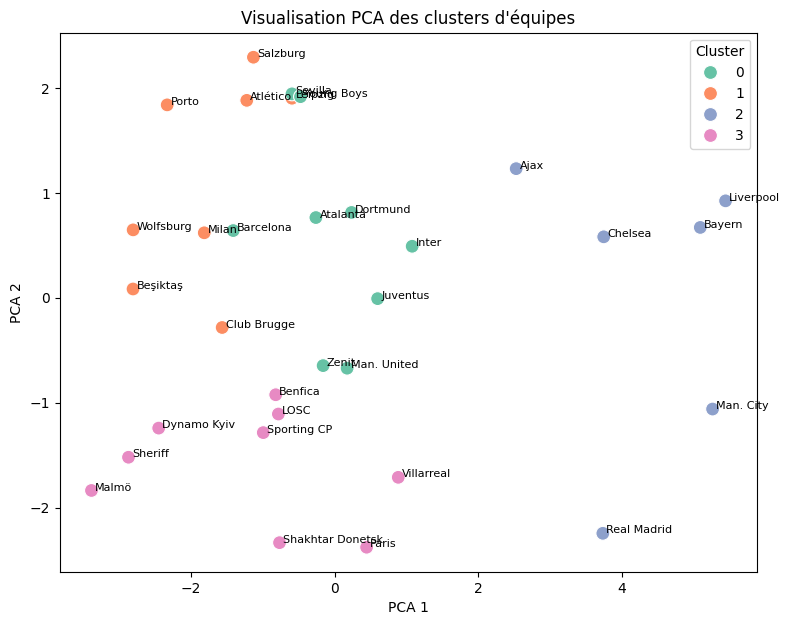

                club  cluster
1           Atalanta        0
3          Barcelona        0
11             Inter        0
9           Dortmund        0
12          Juventus        0
31             Zenit        0
30        Young Boys        0
18       Man. United        0
24           Sevilla        0
23          Salzburg        1
19             Milan        1
29         Wolfsburg        1
14           Leipzig        1
8        Club Brugge        1
2           Atlético        1
6           Beşiktaş        1
21             Porto        1
17         Man. City        2
7            Chelsea        2
22       Real Madrid        2
0               Ajax        2
4             Bayern        2
15         Liverpool        2
5            Benfica        3
13              LOSC        3
10       Dynamo Kyiv        3
20             Paris        3
16             Malmö        3
27       Sporting CP        3
26           Sheriff        3
25  Shakhtar Donetsk        3
28        Villarreal        3


In [6]:
# ===============================
# 🧭 PCA pour visualisation 2D
# ===============================
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
team_stats["pca1"], team_stats["pca2"] = coords[:, 0], coords[:, 1]

plt.figure(figsize=(9,7))
sns.scatterplot(data=team_stats, x="pca1", y="pca2", hue="cluster", palette="Set2", s=100)
for i, row in team_stats.iterrows():
    plt.text(row["pca1"]+0.05, row["pca2"], row["club"], fontsize=8)  # label équipe
plt.title("Visualisation PCA des clusters d'équipes")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# ===============================
# 📝 Top équipes par cluster
# ===============================
print(team_stats[["club", "cluster"]].sort_values("cluster"))

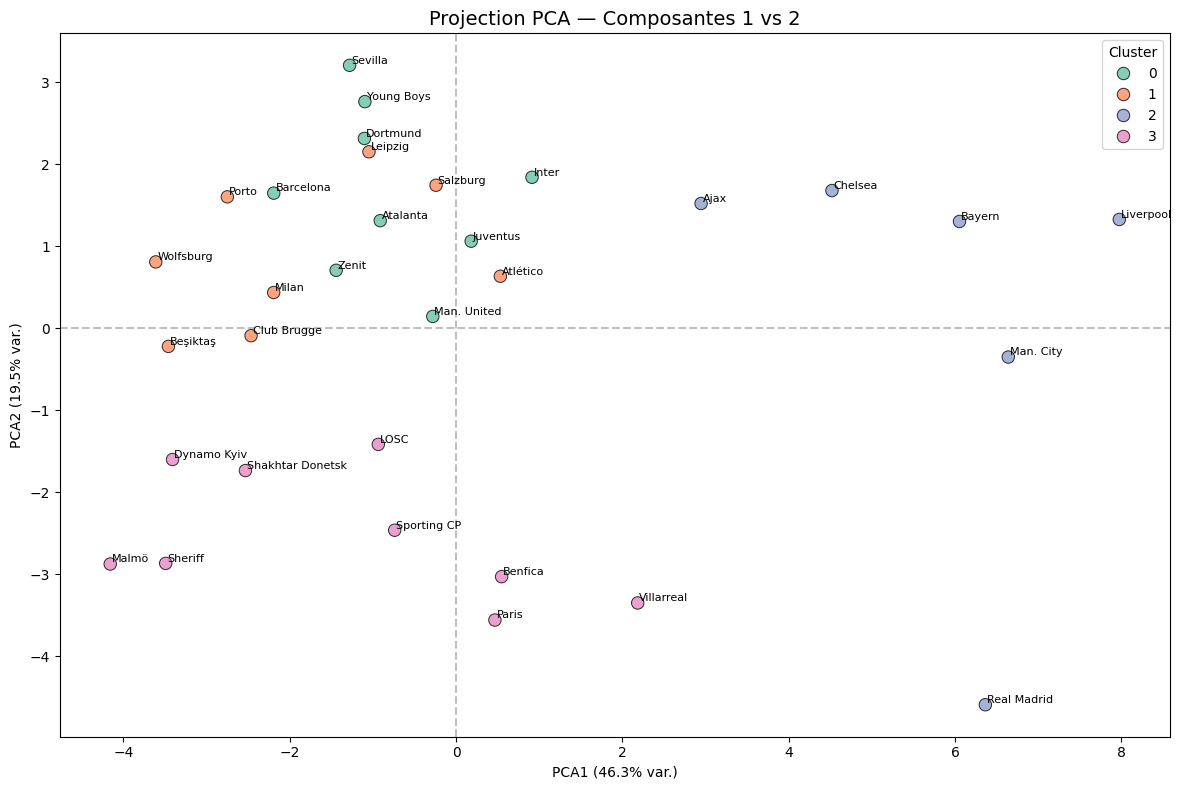

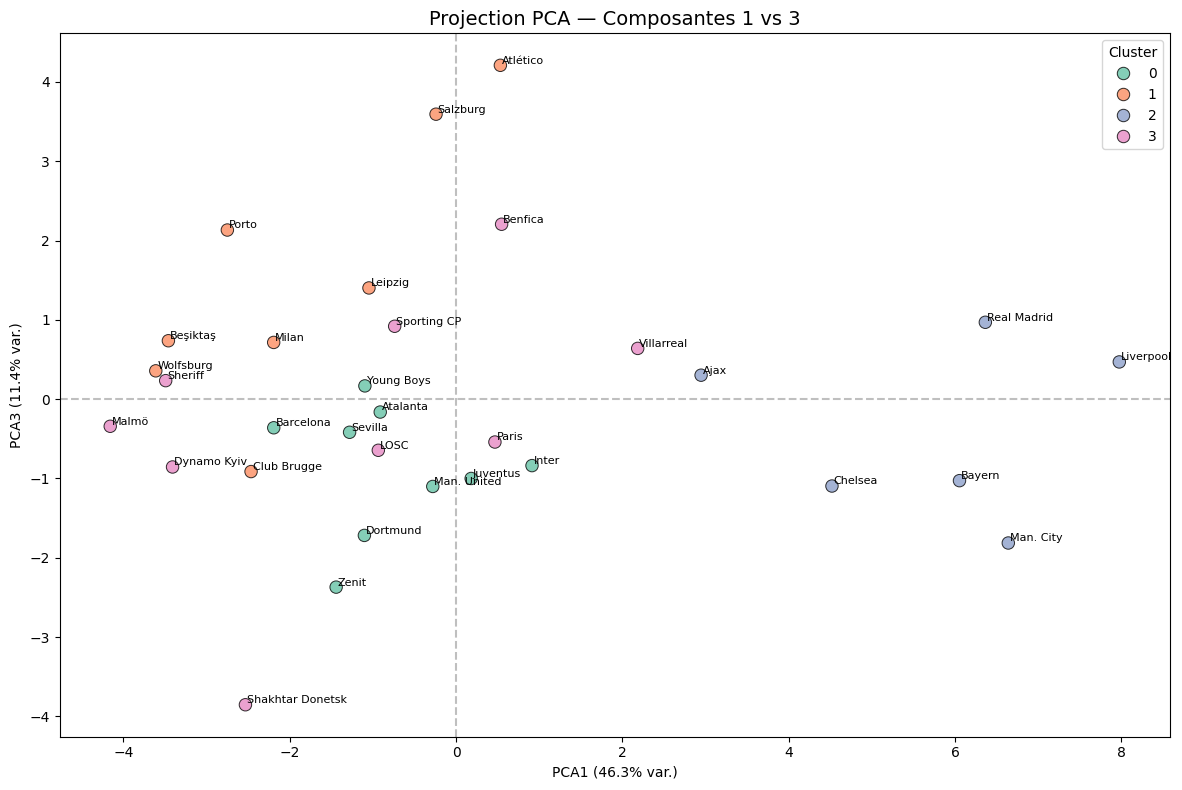

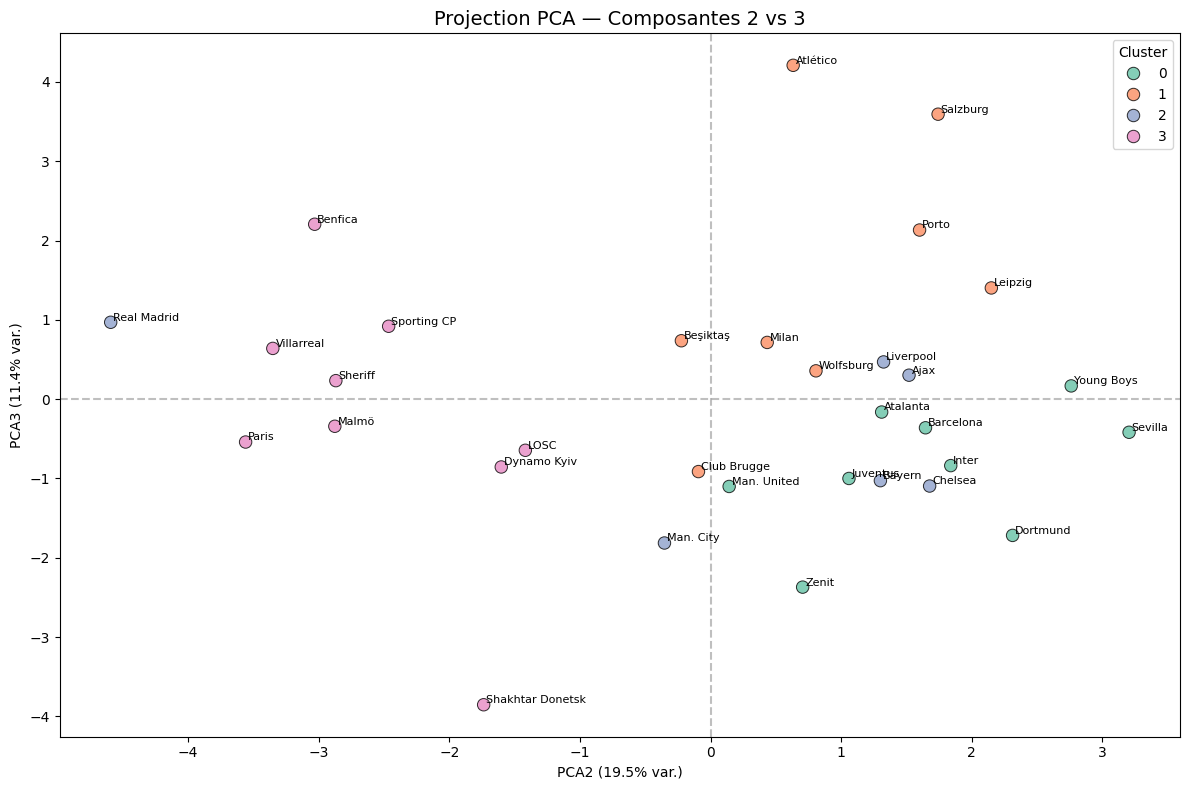

In [7]:
# === Sélection des variables numériques ===
num_cols = team_stats.select_dtypes(include='number').columns.drop(['total_minutes'])
X = team_stats[num_cols]

# === Standardisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === PCA ===
pca = PCA(n_components=5)
coords = pca.fit_transform(X_scaled)

# Ajouter les coordonnées PCA au DataFrame
for i in range(pca.n_components_):
    team_stats[f'PCA{i+1}'] = coords[:, i]

# === Fonction de plot avec labels ===
def plot_pca_with_labels(x_pc, y_pc):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=team_stats,
        x=f'PCA{x_pc}',
        y=f'PCA{y_pc}',
        hue='cluster',
        palette='Set2',
        s=80,
        alpha=0.8,
        edgecolor='black'
    )
    
    # Ajouter le nom des clubs
    for i in range(len(team_stats)):
        plt.text(
            team_stats[f'PCA{x_pc}'].iloc[i] + 0.02,   # petit décalage pour lisibilité
            team_stats[f'PCA{y_pc}'].iloc[i] + 0.02,
            team_stats['club'].iloc[i],
            fontsize=8
        )

    plt.title(f'Projection PCA — Composantes {x_pc} vs {y_pc}', fontsize=14)
    plt.xlabel(f'PCA{x_pc} ({pca.explained_variance_ratio_[x_pc-1]*100:.1f}% var.)')
    plt.ylabel(f'PCA{y_pc} ({pca.explained_variance_ratio_[y_pc-1]*100:.1f}% var.)')
    plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# === Exemples d'affichage ===
plot_pca_with_labels(1, 2)
plot_pca_with_labels(1, 3)
plot_pca_with_labels(2, 3)

In [8]:
# Les loadings = contributions des variables à chaque composante
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PCA{i+1}' for i in range(pca.n_components_)],
    index=num_cols
)

# On trie pour voir les plus fortes contributions sur chaque axe
for i in range(3):  # ici PCA1 à PCA3
    print(f"\n--- Principales variables pour PCA{i+1} ---")
    print(loadings[f'PCA{i+1}'].sort_values(ascending=False).head(5))
    print(loadings[f'PCA{i+1}'].sort_values(ascending=True).head(5))



--- Principales variables pour PCA1 ---
total_attempts    0.306005
on_target         0.304162
pca1              0.302638
pass_attempted    0.300610
goals             0.298098
Name: PCA1, dtype: float64
saved_per90             -0.174446
tackles_per90           -0.099446
fouls_suffered_per90    -0.071735
fouls_committed_per90   -0.050155
balls_recoverd_per90    -0.024542
Name: PCA1, dtype: float64

--- Principales variables pour PCA2 ---
pca2                     0.431261
cross_attempted_per90    0.374103
balls_recoverd_per90     0.333144
fouls_committed_per90    0.274930
cross_attempted          0.144463
Name: PCA2, dtype: float64
saved            -0.379569
cluster          -0.372445
saved_per90      -0.272535
tackles          -0.206636
fouls_suffered   -0.203003
Name: PCA2, dtype: float64

--- Principales variables pour PCA3 ---
tackles_per90            0.386361
tackles                  0.353898
fouls_committed_per90    0.349930
fouls_committed          0.313258
pca2                   

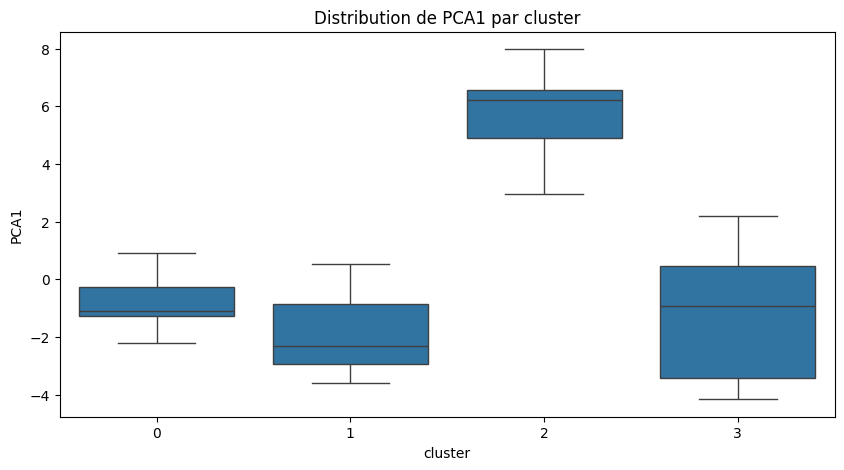

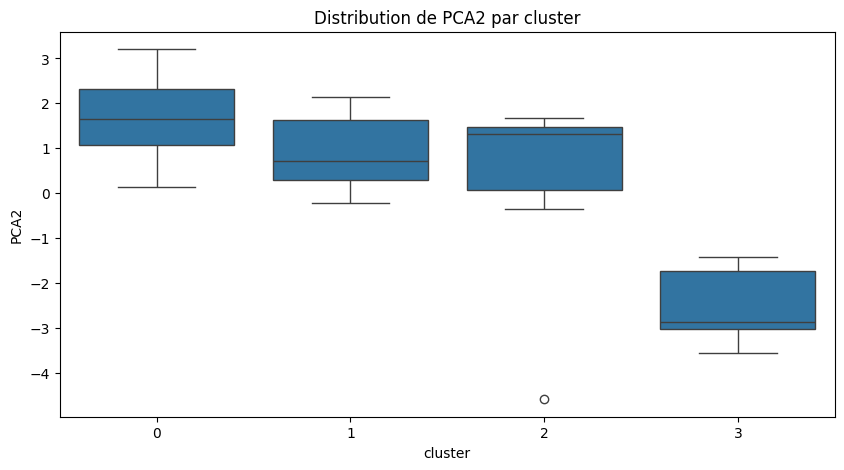

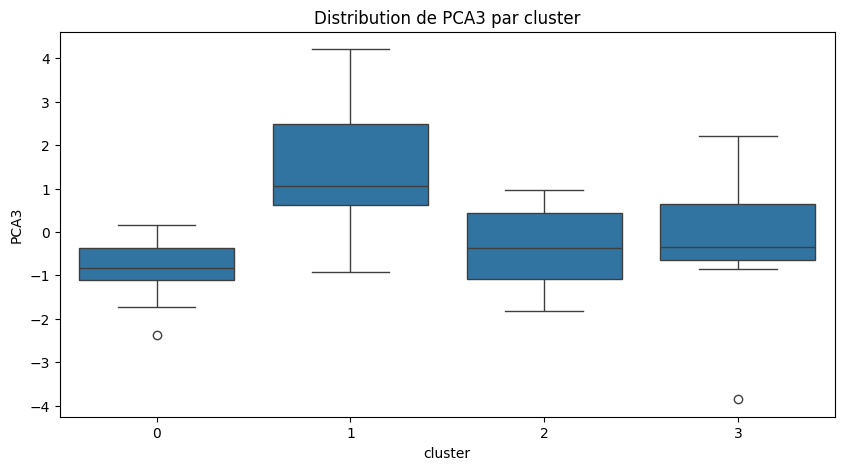

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(data=team_stats, x='cluster', y='PCA1')
plt.title('Distribution de PCA1 par cluster')


plt.figure(figsize=(10,5))
sns.boxplot(data=team_stats, x='cluster', y='PCA2')
plt.title('Distribution de PCA2 par cluster')

plt.figure(figsize=(10,5))
sns.boxplot(data=team_stats, x='cluster', y='PCA3')
plt.title('Distribution de PCA3 par cluster')
plt.show()


Interprétation :

PCA :

PCA 1 : équipes dominantes offensivement et tirant beaucoup.

PCA 2 : équipes qui défendent beaucoup et jouent sur les ailes.

PCA 3 : équipes qui ont souvent recours à leur gardien, encaissent plus d’occasions et réussissent moins de passes.

Cluster :

Cluster 0 : Équipes offensives solides : bon volume offensif, juste en dessous des top clubs, bonne précision de passes, défense correcte, peu de fautes commises, mais moins impressionnantes que celles du cluster 2.

Cluster 1 : Équipes équilibrées mais plus faibles : moins de passes et de tirs, précision technique moindre, plus d’activité défensive.

Cluster 2 : Top clubs dominateurs : très hauts volumes offensifs (tirs, tirs cadrés, dribbles, buts, passes), très bonne précision de passes, peu sollicités défensivement.

Cluster 3 : Petits clubs ou styles plus défensifs : volume offensif plus faible, moins de centres et de passes, beaucoup d’arrêts du gardien (donc plus sous pression).

Ces critères montrent le style de jeu des différentes équipes, mais ne déterminent pas forcément le résultat final. Par exemple, Villarreal, dans le cluster 3, a réussi à atteindre les demi-finales, alors que Chelsea et l’Ajax, clubs plus dominateurs du cluster 2, sont sortis respectivement en quart de finale et en huitième de finale.